In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import matplotlib.animation as animation

In [2]:
from collections import namedtuple
import itertools  
import scipy as sp
import scipy.linalg

In [85]:
def Sol2Anim(limits, U):
    print(limits)
    x0, x1, y0, y1, t0, t1 = limits
    nt, nx, ny = U.shape
    X = np.linspace(x0,x1,nx)
    Y = np.linspace(y0,y1,ny)
    T = np.linspace(t0,t1,nt)
    
    print(f"nt, nx, ny = {U.shape}")
    
    ###########

    fig = plt.figure(figsize=(16, 8),facecolor='white')
    
    ax = fig.add_subplot(111)
    
    z = U[0].copy()
    quad = ax.pcolormesh(X,Y,z,shading='nearest',vmin=0, vmax=5)
    ax.set_xlabel('x')
    ax.set_ylabel('y')
    ax.set_title('t = 0')
    cb = fig.colorbar(quad,ax=ax)

    def init():
        return quad,

    checkpoints = [1, 0.8, 0.6, 0.4, 0.2, 0]
    def animate(n):
        ax.set_title(f"t = {T[n]}")
        quad.set_array(U[n].ravel())
        # quad.set_clim(0, U[n].max())
        if n >= checkpoints[-1] * nt:
            print(f"Animation rendering: {n}/{nt}")
            checkpoints.pop()
        return quad,

    anim = animation.FuncAnimation(fig,animate,frames=nt,init_func=init,interval=100,blit=False,repeat=False)
    
    anim.save('explicit1.mp4')
    
    return anim, quad, fig, ax

def Sol2LastFrame(U, X, Y, title):
    plt.pcolormesh(X, Y, U[-1], shading='nearest')
    plt.colorbar()
    plt.gca().set_aspect(1)
    plt.title(title)

# Розрахункова робота
Михайло Корешков, ФІ-91, Варіант 6

$$\frac{dn}{dt} = -\gamma n + \alpha \cdot m(n) n^2 + D(\frac{d^2n}{dx^2} + \frac{d^2n}{dy^2}) $$
$$m(n) = m_0 \exp\{-\frac{n}{n_0}\}$$

Граничні умови:

$$n|_\Gamma = const = n_0$$
$$n|_{t=0} = n_0$$

($\Gamma$ - межа простору, що розглядається)

Я використовуватиму в коді наступну нотацію:

- $u(t,x,y)$ - шукана функція
- $X, Y$ - можливі значення $x, y$
- $u(0, x, y) = u_0 = const$
- $\Gamma = (X\times \{0\}) \cup (X\times \{1\}) \cup (\{0\} \times Y) \cup (\{1\} \times Y)$
- $\forall \vec x \in \Gamma: u(t, \vec x) = const = u_0$
- Параметри моделі: $\gamma, \alpha, m_0, u_0, D = const$

$$\dot u(t,\vec x) = f(t,\vec x) = -\gamma u(t,\vec x) + \alpha m_0 \exp\{-\frac{u}{u_0}\} u(t, \vec x)^2 + D\Delta u(t, \vec x) $$
$$\Delta u = \nabla^2 u$$

---

Визначимо параметри. $\beta = \frac{\alpha m_0}{e}$

In [4]:
Params = namedtuple('Params', ['k', 'h', 'gamma', 'beta', 'u0', 'D'])

Limits = namedtuple('Limits', ['x0', 'x1', 'y0', 'y1', 't0', 't1'])

LIMITS = Limits(0, 1, 0, 1, 0, 1)
LIMITS

Limits(x0=0, x1=1, y0=0, y1=1, t0=0, t1=1)

Також визначимо початкові та граничні умови:

In [5]:
def GetU0(params, X, Y):
    k, h, gamma, beta, u0, D = params
    
    u = np.ones((X.shape[0], Y.shape[0]))
    return u * u0

def SetBoundary_inplace(params, u):
    u0 = params.u0
    u[0, :] = u0
    u[-1, :] = u0
    u[:, 0] = u0
    u[:, -1] = u0

---

## Скіненно-різницева модель
Тепер необхідно записати $f(t,\vec x)$ у скінченно-різницевому вигляді.

### 0. Оператор лапласа ($\Delta$)
Одновимірний:
$$\Delta u(x)=u''(x)\approx {\frac {u(x-h)-2u(x)+u(x+h)}{h^{2}}}=:\Delta _{h}u(x)$$

Двовимірний:

$$\begin{aligned}\Delta u(x,y) &= u_{xx}(x,y)+u_{yy}(x,y) \\ &\approx {\frac {u(x-h,y)-2u(x,y)+u(x+h,y)}{h^{2}}}+{\frac {u(x,y-h)-2u(x,y)+u(x,y+h)}{h^{2}}} \\ &= {\frac {u(x-h,y)+u(x+h,y)-4u(x,y)+u(x,y-h)+u(x,y+h)}{h^{2}}} \\ &=:\Delta _{h}u(x,y)\end{aligned}$$

### 1. Явний спосіб

Задаємо часовий крок $k = const$ та просторовий крок $h = const$. 
$$t_0 = 0; \quad t_{k+1} = t_k + k$$
$$x_0, y_0 = 0; \quad x_{k+1} = x_k + h; \; y_{k+1} = y_k + h$$

Позначатимемо 
$$u(t_n, x_i, y_j) = u_{ij}^n; \quad u(t_n, x, y) = u^n(x,y)$$

Далі просто замінюємо диференціальні оператори на їх скінченно-різницеві варіанти, а потім алгеброю виражаємо $u^{n+1}$ через $u^n$

$$\dot u(t,\vec x) = f(t,\vec x) = -\gamma u(t,\vec x) + \alpha m_0 \exp\{-\frac{u}{u_0}\} u(t, \vec x)^2 + D\Delta u(t, \vec x) $$

$$\frac{u^{n+1}_{ij} - u^n_{ij}}{k} = -\gamma u^n_{ij} + \alpha m_0 \exp\{-\frac{u^n_{ij}}{u_0}\} (u^n_{ij})^2 + \frac{D}{h^2} \left(u^n_{i-1j}+u^n_{i+1j}-4u^n_{ij}+u^n_{ij-1}+u^n_{ij+1}\right)$$

$$u^{n+1}_{ij} = u^n_{ij} + k \cdot \left(-\gamma u^n_{ij} + \alpha m_0 \exp\{-\frac{u^n_{ij}}{u_0}\} (u^n_{ij})^2 + \frac{D}{h^2} \left(u^n_{i-1j}+u^n_{i+1j}-4u^n_{ij}+u^n_{ij-1}+u^n_{ij+1}\right)\right)$$

Також для стійкості явного способу рекомендовано $r = \frac{k}{h^2} \le 0.5$.

In [6]:
# u11 -> u_ij;    u21 -> u_i+1j;    u01 -> u_i-1j;
# Params(gamma=0.5, alpha=0.5, m0=1, u0=1, D=0.5)
def ExplicitNext(params, limits, u_prev, i, j, stencil=1):
    S1 = np.array([
        [0, 1, 0],
        [1, -4, 1],
        [0, 1, 0]
    ])
    S2 = np.array([
        [1, 4, 1],
        [4, -20, 4],
        [1, 4, 1]
    ])
    Stencils = [S1, S2]
    S = Stencils[stencil-1]
    
    k, h, gamma, beta, u0, D = params
    
    uij = u_prev[i,j]
    
    # Note: (S*u[i-1:i+1, j-1:j+1]).sum() is a finite laplacian
    delta = ( -gamma * uij + beta * np.e * np.exp(-uij / u0) * uij * uij + (S*u_prev[i-1:i+2, j-1:j+2]).sum() * D / (h*h) )
    # print(f"u_{i},{j} delta = {delta}")
    
    return uij + k*delta


def ExplicitSolve(params, limits, stencil=1):
    k, h, gamma, beta, u0, D = params
    x0, x1, y0, y1, t0, t1 = limits
    
    print("Starting explicit solver with", params, " and ", limits)
    
    nx = int( (x1-x0)/h ) + 1
    ny = int( (y1-y0)/h ) + 1
    nt = int( (t1-t0)/k ) + 1
    
    X = np.linspace(x0, x1, nx) # .reshape(-1,1)
    Y = np.linspace(y0, y1, ny)
    T = np.linspace(t0, t1, nt)
    
    U = np.zeros((nt,nx,ny))
    
    U[0] = GetU0(params, X, Y)
    
    for n in range(1,nt):
        u_next = np.empty((nx,ny))
        for i in range(1,nx-1):
            for j in range(1,ny-1):
                u_next[i,j] = ExplicitNext(params, limits, U[n-1], i, j, stencil)
                
        SetBoundary_inplace(params, u_next)
        u_next[u_next<0]=0
        U[n] = u_next.copy()
        
    return U,X,Y,T
    
    
    

## Попередній аналіз рівняння

Перед симуляцією я хочу знайти рівноваги цієї моделі. Тобто знайти, як мають співвідноситися параметри, щоб $u$ залишалась сталою.

> Хочу зауважити, що за наших граничних умов ми маємо необмежене та константне "джерело" $u$ на границі досліджуваної області. Поки я це ігноруватиму.

Розпочнаємо зі сталого розподілу та хочемо, щоб він залишався таким. значить не має сенсу розглядати $u(t,x,y)$; у рівнянні достатньо замінити $u$ на $u_0$ - початкове значення.

Також я заміню добуток $\alpha m_0$ на спільний параметр $\beta_1$ що відповідатиме за народжуваність, бо ці два параметри не мають сенсу окремо.

Маємо 
$$-\gamma u_0 + \alpha m_0 \exp\{-\frac{u_0}{u_0}\} u_0^2 = 0$$
$$-\gamma + \beta_1 e^{-1} u_0 = 0$$

А тут з'являється фактор $e^{-1}$. Підлаштую параметр $\beta = \beta_1 e^{-1} = \alpha m_0 e^{-1}$. Маємо

$$ \frac{\gamma}{\beta} = u_0$$
або
$$p := \frac{u_0\beta}{\gamma} = 1$$

Отримали співвідношення, за якого популяція залишатиметься сталою

## Результати симуляції
Тепер можемо пробувати розв'язувати рівняння з різними параметрами.

У нас фактично є 3 параметри, які можна змінювати: $\beta$, $\gamma$ та $u_0$. 

Спочатку оберу рівноважну комбінацію параметрів. А потім буду від неї відштовхуватись, змінюючи кожен параметр окремо. Нехай нею буде $\quad u_0 = 10, \quad \gamma = 10, \quad \beta = 1$

Також, експерементальним шляхом та за допомогою відношення $\frac{k}{h^2} < 0.5$ було підібрано оптимальні кроки - $k=0.001, h=0.05$ 

### 0. Нейтральне положення

Бачимо, що співвідношення працює - система стала

Starting explicit solver with Params(k=0.001, h=0.05, gamma=10, beta=1, u0=10, D=0.05)  and  Limits(x0=0, x1=1, y0=0, y1=1, t0=0, t1=1)


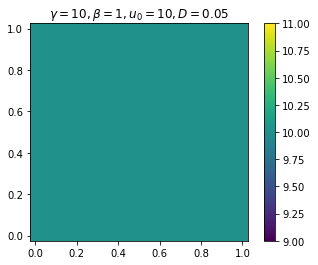

In [7]:
# 0. Stable
params1 = Params( k=0.001, h=0.05, gamma=10, beta=1, u0=10, D = 0.05 )
solution_explicit, X1, Y1, T1 = ExplicitSolve(params1, LIMITS)
Sol2LastFrame(solution_explicit, X1, Y1, f"$\gamma={params1.gamma}, \\beta={params1.beta}, u_0={params1.u0}, D={params1.D}$")

### 1. Мала дифузія

In [8]:
list(itertools.product([1,2,3], [1, 10, 100]))

[(1, 1),
 (1, 10),
 (1, 100),
 (2, 1),
 (2, 10),
 (2, 100),
 (3, 1),
 (3, 10),
 (3, 100)]

In [9]:
mortality = [ 5  , 10, 20 ]
fertility = [ 0.5, 1 , 2  ]

combinations = itertools.product(mortality, fertility)

solutions = []
X1, Y1, T1

for gamma, beta in combinations:
    param = Params( k=0.001, h=0.05, gamma=gamma, beta=beta, u0=10, D = 0.05 )
    solution_explicit, X1, Y1, T1 = ExplicitSolve(param, LIMITS)
    solutions.append((solution_explicit[-1], param))

Starting explicit solver with Params(k=0.001, h=0.05, gamma=5, beta=0.5, u0=10, D=0.05)  and  Limits(x0=0, x1=1, y0=0, y1=1, t0=0, t1=1)
Starting explicit solver with Params(k=0.001, h=0.05, gamma=5, beta=1, u0=10, D=0.05)  and  Limits(x0=0, x1=1, y0=0, y1=1, t0=0, t1=1)
Starting explicit solver with Params(k=0.001, h=0.05, gamma=5, beta=2, u0=10, D=0.05)  and  Limits(x0=0, x1=1, y0=0, y1=1, t0=0, t1=1)
Starting explicit solver with Params(k=0.001, h=0.05, gamma=10, beta=0.5, u0=10, D=0.05)  and  Limits(x0=0, x1=1, y0=0, y1=1, t0=0, t1=1)
Starting explicit solver with Params(k=0.001, h=0.05, gamma=10, beta=1, u0=10, D=0.05)  and  Limits(x0=0, x1=1, y0=0, y1=1, t0=0, t1=1)
Starting explicit solver with Params(k=0.001, h=0.05, gamma=10, beta=2, u0=10, D=0.05)  and  Limits(x0=0, x1=1, y0=0, y1=1, t0=0, t1=1)
Starting explicit solver with Params(k=0.001, h=0.05, gamma=20, beta=0.5, u0=10, D=0.05)  and  Limits(x0=0, x1=1, y0=0, y1=1, t0=0, t1=1)
Starting explicit solver with Params(k=0.001,

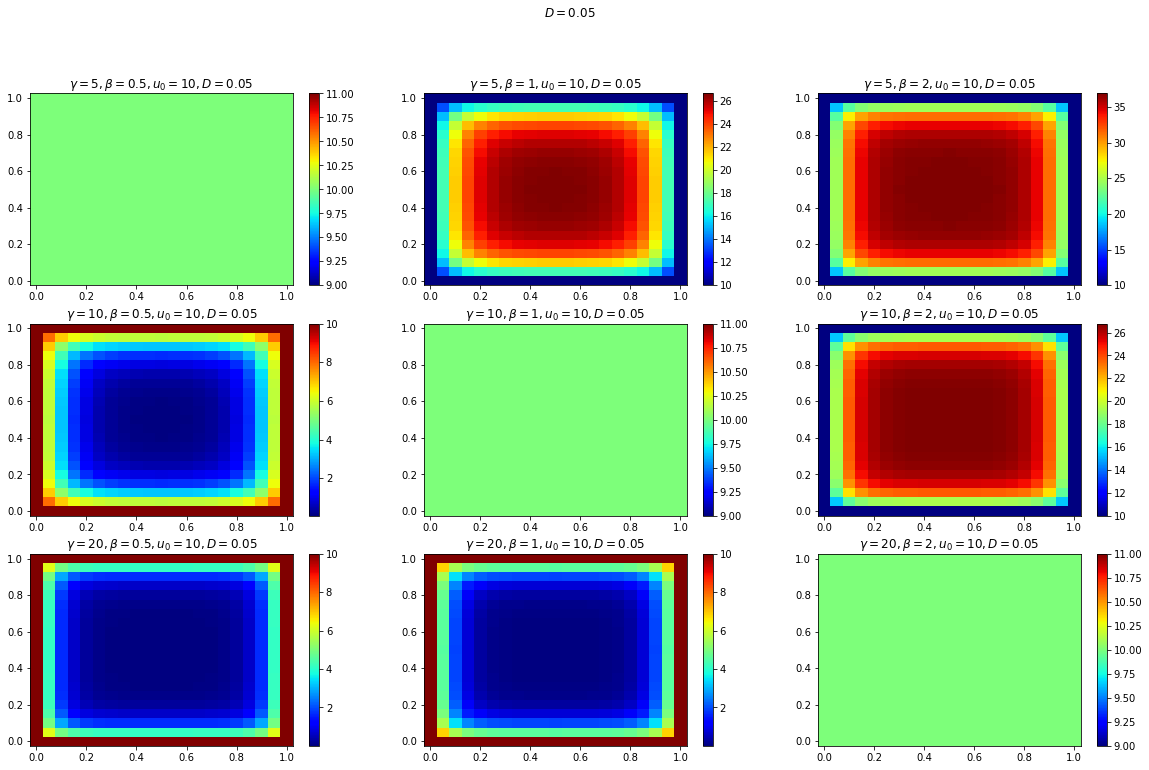

In [10]:
fig, axs = plt.subplots(3,3)
fig.suptitle("$D = 0.05$")

for i, (sol, param) in enumerate(solutions):
    ax = plt.subplot(3,3,i+1)
    quad = ax.pcolormesh(X1, Y1, sol, cmap='jet')
    fig.colorbar(quad, ax=ax)
    ax.set_title(f"$\gamma={param.gamma}, \\beta={param.beta}, u_0=10, D=0.05$")
    
fig.set_size_inches((20,12))

### 2. Побільше дифузії

In [11]:
mortality = [ 5  , 10, 20 ]
fertility = [ 0.5, 1 , 2  ]

combinations = itertools.product(mortality, fertility)

solutions = []
X1, Y1, T1

for gamma, beta in combinations:
    param = Params( k=0.001, h=0.05, gamma=gamma, beta=beta, u0=10, D = 0.2 )
    solution_explicit, X1, Y1, T1 = ExplicitSolve(param, LIMITS)
    solutions.append((solution_explicit[-1], param))

Starting explicit solver with Params(k=0.001, h=0.05, gamma=5, beta=0.5, u0=10, D=0.2)  and  Limits(x0=0, x1=1, y0=0, y1=1, t0=0, t1=1)
Starting explicit solver with Params(k=0.001, h=0.05, gamma=5, beta=1, u0=10, D=0.2)  and  Limits(x0=0, x1=1, y0=0, y1=1, t0=0, t1=1)
Starting explicit solver with Params(k=0.001, h=0.05, gamma=5, beta=2, u0=10, D=0.2)  and  Limits(x0=0, x1=1, y0=0, y1=1, t0=0, t1=1)
Starting explicit solver with Params(k=0.001, h=0.05, gamma=10, beta=0.5, u0=10, D=0.2)  and  Limits(x0=0, x1=1, y0=0, y1=1, t0=0, t1=1)
Starting explicit solver with Params(k=0.001, h=0.05, gamma=10, beta=1, u0=10, D=0.2)  and  Limits(x0=0, x1=1, y0=0, y1=1, t0=0, t1=1)
Starting explicit solver with Params(k=0.001, h=0.05, gamma=10, beta=2, u0=10, D=0.2)  and  Limits(x0=0, x1=1, y0=0, y1=1, t0=0, t1=1)
Starting explicit solver with Params(k=0.001, h=0.05, gamma=20, beta=0.5, u0=10, D=0.2)  and  Limits(x0=0, x1=1, y0=0, y1=1, t0=0, t1=1)
Starting explicit solver with Params(k=0.001, h=0.05

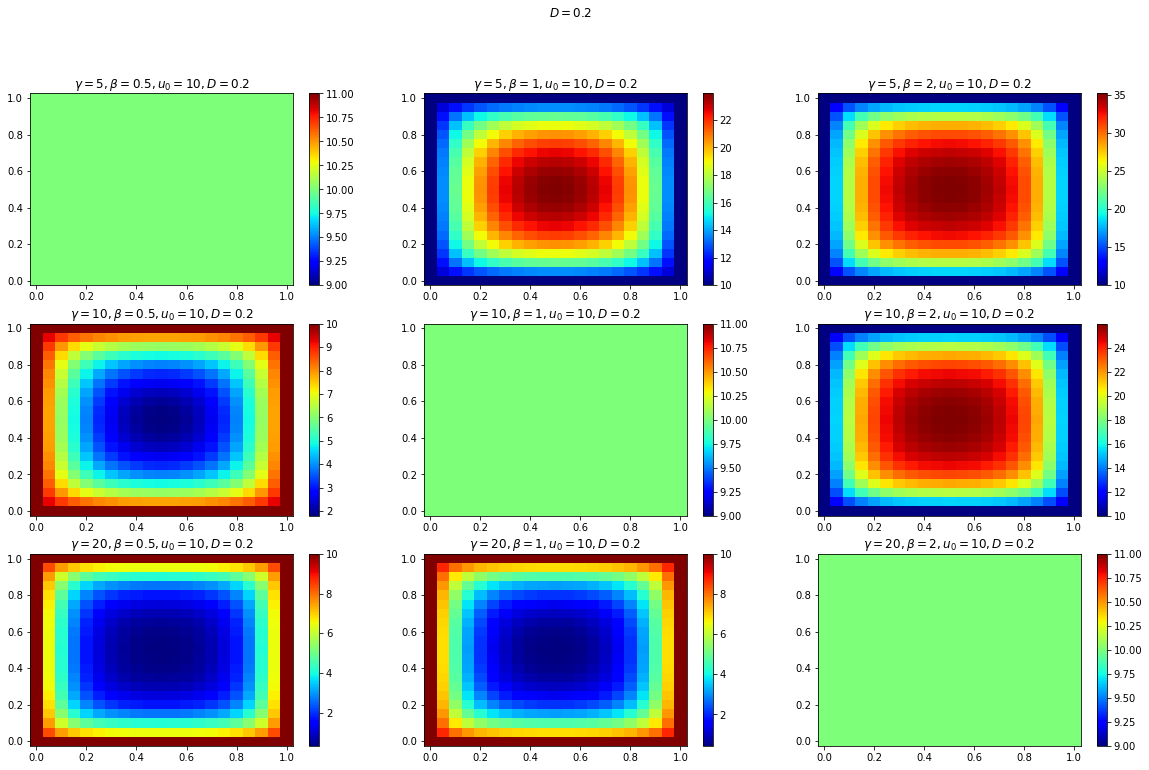

In [12]:
fig, axs = plt.subplots(3,3)
fig.suptitle("$D = 0.2$")

for i, (sol, param) in enumerate(solutions):
    ax = plt.subplot(3,3,i+1)
    quad = ax.pcolormesh(X1, Y1, sol, cmap='jet')
    fig.colorbar(quad, ax=ax)
    ax.set_title(f"$\gamma={param.gamma}, \\beta={param.beta}, u_0=10, D=0.2$")
    
fig.set_size_inches((20,12))

### 3. Багато дифузії

In [13]:
mortality = [ 5  , 10, 20 ]
fertility = [ 0.5, 1 , 2  ]

combinations = itertools.product(mortality, fertility)

solutions = []
X1, Y1, T1

for gamma, beta in combinations:
    param = Params( k=0.001, h=0.05, gamma=gamma, beta=beta, u0=10, D = 1 )
    solution_explicit, X1, Y1, T1 = ExplicitSolve(param, LIMITS)
    solutions.append((solution_explicit, param))

Starting explicit solver with Params(k=0.001, h=0.05, gamma=5, beta=0.5, u0=10, D=1)  and  Limits(x0=0, x1=1, y0=0, y1=1, t0=0, t1=1)
Starting explicit solver with Params(k=0.001, h=0.05, gamma=5, beta=1, u0=10, D=1)  and  Limits(x0=0, x1=1, y0=0, y1=1, t0=0, t1=1)
Starting explicit solver with Params(k=0.001, h=0.05, gamma=5, beta=2, u0=10, D=1)  and  Limits(x0=0, x1=1, y0=0, y1=1, t0=0, t1=1)
Starting explicit solver with Params(k=0.001, h=0.05, gamma=10, beta=0.5, u0=10, D=1)  and  Limits(x0=0, x1=1, y0=0, y1=1, t0=0, t1=1)
Starting explicit solver with Params(k=0.001, h=0.05, gamma=10, beta=1, u0=10, D=1)  and  Limits(x0=0, x1=1, y0=0, y1=1, t0=0, t1=1)
Starting explicit solver with Params(k=0.001, h=0.05, gamma=10, beta=2, u0=10, D=1)  and  Limits(x0=0, x1=1, y0=0, y1=1, t0=0, t1=1)
Starting explicit solver with Params(k=0.001, h=0.05, gamma=20, beta=0.5, u0=10, D=1)  and  Limits(x0=0, x1=1, y0=0, y1=1, t0=0, t1=1)
Starting explicit solver with Params(k=0.001, h=0.05, gamma=20, be

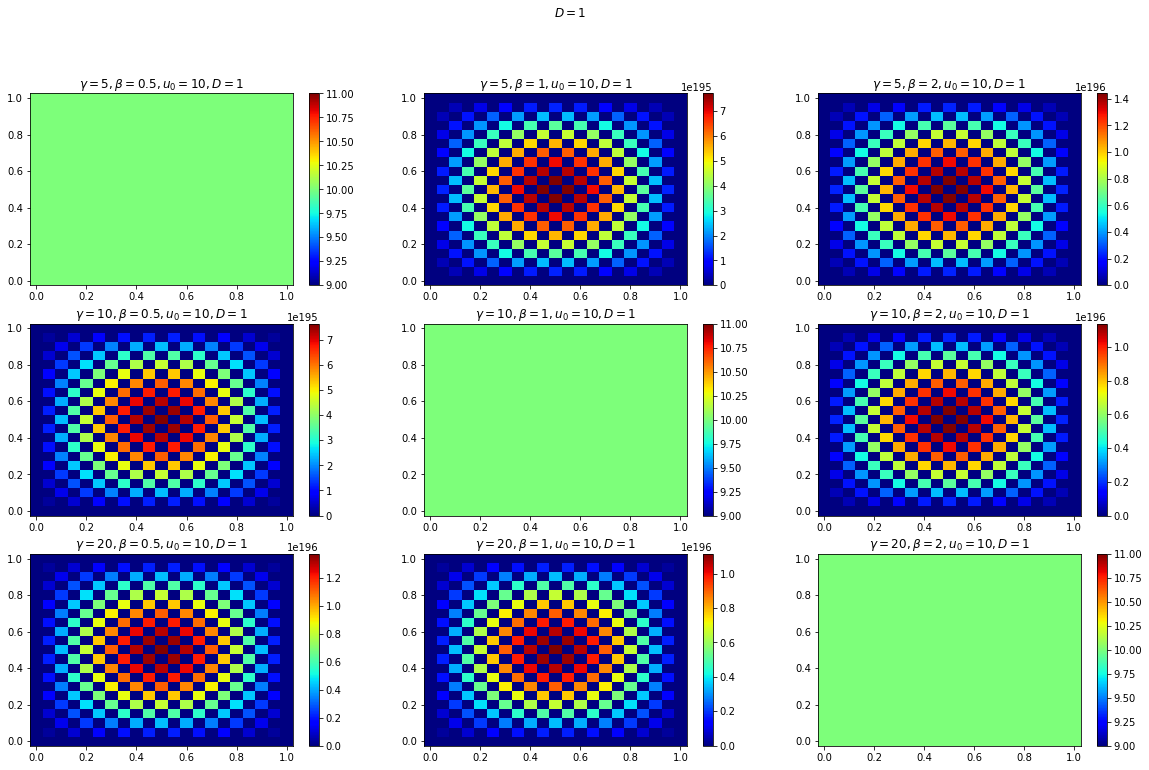

In [14]:
fig, axs = plt.subplots(3,3)
fig.suptitle("$D = 1$")

for i, (sol, param) in enumerate(solutions):
    ax = plt.subplot(3,3,i+1)
    quad = ax.pcolormesh(X1, Y1, sol[-1], cmap='jet')
    fig.colorbar(quad, ax=ax)
    ax.set_title(f"$\gamma={param.gamma}, \\beta={param.beta}, u_0=10, D=1$")
    
fig.set_size_inches((20,12))

Бачимо, що тут алгоритм вже дає щось не таке зрозуміле, як раніше. Можливо, для таких параметрів мені недостатньо точності. Або тут грає роль "нескінченне джерело" на границі області. Можемо подивитися на ці самі розв'язки в перші моменти часу

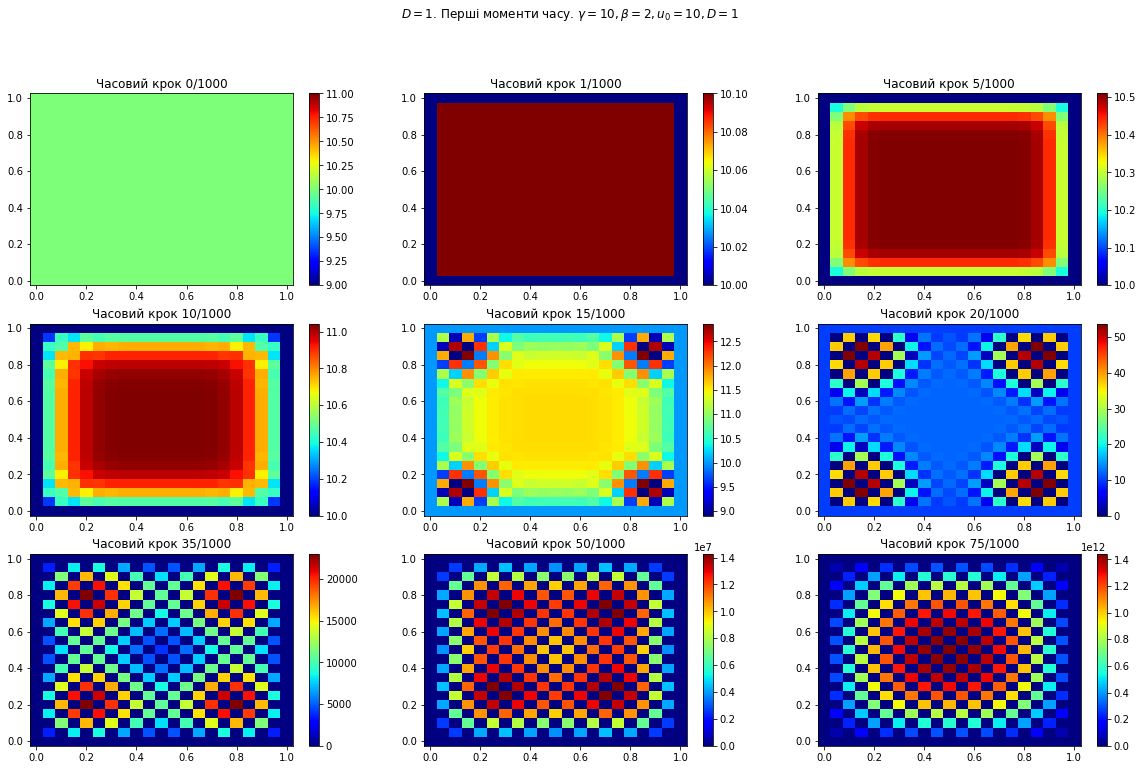

In [15]:
fig, axs = plt.subplots(3,3)
param = solutions[5][1]
fig.suptitle(f"$D = 1$. Перші моменти часу. $\gamma={param.gamma}, \\beta={param.beta}, u_0=10, D=1$")

for i, n in enumerate([0, 1, 5, 10, 15, 20, 35, 50, 75]):
    ax = plt.subplot(3,3,i+1)
    quad = ax.pcolormesh(X1, Y1, solutions[5][0][n], cmap='jet')
    fig.colorbar(quad, ax=ax)
    ax.set_title(f"Часовий крок {n}/1000")
    
fig.set_size_inches((20,12))

### Висновки
Для обчислень використаний явний метод скінченних різниць.

Результати моделювання збігаються з інтуїтивним розумінням процесу: 
> Якщо народжуваність більша за смертність, то кількість особин зростає. 

> Якщо навпаки - то падає до мінімуму, що в свої чергу регулюється швидкістю міграції та інтенсивністю "джерела" особин на межі області. 


## 2. Неявний спосіб

Також називається як метод Кранка-Нікольсона

Основна різниця буде у дискретному вигляді правої частини диф рівняння. Тепер вона обчислюватиметься зі значень не лише попереднього часового кроку, а й "теперішнього" з вагою $\sigma$

$$u(t_n,x_i,y_j) \longrightarrow \hat u_{ij}^n = (1-\sigma) u_{ij}^n + \sigma u_{ij}^{n+1}$$
$$\nabla^2 u(t_n,x_i,y_j) \longrightarrow (1-\sigma)D^2u_{ij}^n + \sigma D^2u_{ij}^{n+1} = $$
$$= \frac{1}{h^2} (1-\sigma)\left(u^n_{i-1j}+u^n_{i+1j}-4u^n_{ij}+u^n_{ij-1}+u^n_{ij+1}\right) + \frac{1}{h^2} \sigma\left(u^{n+1}_{i-1j}+u^{n+1}_{i+1j}-4u^{n+1}_{ij}+u^{n+1}_{ij-1}+u^{n+1}_{ij+1}\right)$$

Наше диф рівняння - нелінійне. Заміну u на двошаровий аналог не вийде провести просто, а результуючі рівняння також будуть нелінійними.

Тому, на жаль, опустимо нелінійний спосіб для цієї задачі та розглянемо натомість задачу більш просту та лінійну. Наприклад, рівняння теплопровідності:
$$\frac{\partial u}{\partial t}(t,x,y) = c\nabla^2u(t,x,y)$$
з граничними умовами
$$u(t,x,y)|_\Gamma = 0; \quad u(0,0.5\pm0.1,0.5\pm0.1)= 1$$

Маємо рівняння
$$\frac{u^{n+1}_{ij} - u^{n}_{ij}}{k}  =\frac{1}{h^2} (1-\sigma)\left(u^n_{i-1j}+u^n_{i+1j}-4u^n_{ij}+u^n_{ij-1}+u^n_{ij+1}\right) + \frac{1}{h^2} \sigma\left(u^{n+1}_{i-1j}+u^{n+1}_{i+1j}-4u^{n+1}_{ij}+u^{n+1}_{ij-1}+u^{n+1}_{ij+1}\right)$$

Зносимо все, що стосується "теперішнього" часу в один бік, а "попереднього моменту часу" - в інший.

$$u^{n+1}_{ij} = u^{n}_{ij} + \frac{k}{h^2} \cdot \left((1-\sigma)\left(u^n_{i-1j}+u^n_{i+1j}-4u^n_{ij}+u^n_{ij-1}+u^n_{ij+1}\right) + \sigma\left(u^{n+1}_{i-1j}+u^{n+1}_{i+1j}-4u^{n+1}_{ij}+u^{n+1}_{ij-1}+u^{n+1}_{ij+1}\right)\right)$$


$$ (1-4\cdot\frac{k\sigma}{h^2})u^{n+1}_{ij} - \frac{k\sigma}{h^2} u^{n+1}_{i-1j} - \frac{k\sigma}{h^2} u^{n+1}_{i+1j} - \frac{k\sigma}{h^2} u^{n+1}_{ij-1} - \frac{k\sigma}{h^2} u^{n+1}_{ij+1} = u^{n}_{ij} + \frac{k(1-\sigma)}{h^2}\left(u^n_{i-1j}+u^n_{i+1j}-4u^n_{ij}+u^n_{ij-1}+u^n_{ij+1}\right) \; \forall i,j = \overline{1,n-1} $$

Для кожного моменту часу $t_n$ маємо $(n_x-2)(n_y-2)$ рівнянь на $(n_x -2)(n_y - 2)$ змінні

Для початку візьмемо широкий просторовий крок та подивимося як виглядає матриця утвореної системи лінійних рівнянь, якщо нумерувати рівняння як $r = (n_x-2) (i-1) + (j-1)$

Суть у тому, що кожній комбінації індексів по x та y треба дати свій номер. Таким ($r$) чином я нумерую пари $(i,j)$ просто беручи номер пари в лесикографічно відсортованому декартовому добутку $\{0, ..., n_x\}\times\{0, ..., n_y\}$.

In [16]:
H1 = 0.25
K1 = 0.1
X2 = np.linspace(0,1,5)
Y2 = np.linspace(0,1,5)
Y2

array([0.  , 0.25, 0.5 , 0.75, 1.  ])

In [70]:
def GenerateImplicitMatrix1(k, h, X, Y, sigma):
    nx, ny = X.shape[0], Y.shape[0]
    n = (nx-2)*(ny-2)
    
    M = np.zeros((n,n))
    
    c1 = -k*sigma/(h*h)
    c2 = 1-4*c1
 
    # c1 = 50
    # c2 = 100
    r = 0
    for i in range(1,nx-1):
        for j in range(1, ny-1):
            M[r,r] = c2
            if i != 1:
                M[r,r-nx+2] = c1
            if i != nx-2:
                M[r,r+nx-2] = c1
            if j != 1:
                M[r,r-1] = c1
            if j != ny-2:
                M[r,r+1] = c1
            r += 1
            
    return M

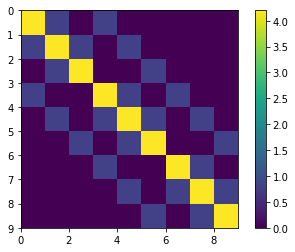

In [71]:
M0 = GenerateImplicitMatrix1(K1, H1, X2, Y2, 0.5)
plt.pcolormesh(np.abs(M0))
plt.ylim(9,0)
plt.colorbar()
plt.gca().set_aspect(1)

Отакий матриця матиме вигляд. Це 7-діагональна матриця. 

Нехай $q = (n_x-2)(n_y-2)$.
Розв'язок 7-мидіагональної матриці виглядає не дуже ефективно порівняно з просто gaussian elimination, але тут необхідно звернути увагу на більші n_x та n_y, в яких відношення непустих елементів до пустих стрімко спадає. Наприклад, наступне зображення показує цю ж матрицю всього при $n_x=n_y=15$

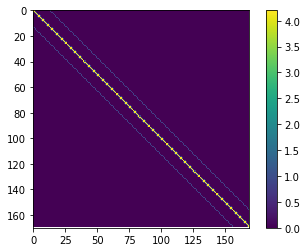

In [72]:
M_sparse = GenerateImplicitMatrix1(K1, H1, np.zeros(15), np.zeros(15), 0.5)
plt.pcolormesh(np.abs(M_sparse))
plt.colorbar()
plt.ylim(170,0)
plt.gca().set_aspect(1)

Повертаємось до задачі. 

Ми маємо матрицю, тепер необхідно обчислити вектор правої частини. А далі можна писати ітеративну процедуру.

In [73]:
def GenerateImplicitB1(k, h, X, Y, sigma, u):
    nx, ny = X.shape[0], Y.shape[0]
    n = (nx-2)*(ny-2)
    B = np.zeros(n)
    
    coef = k * (1-sigma) / (h * h)
    
    r = 0
    for i in range(1, nx-1):
        for j in range(1, ny-1):
            B[r] = u[i,j] + coef * ( -4 * u[i,j] + u[i,j+1] + u[i,j-1] + u[i+1,j] + u[i-1,j] )
            r += 1
    
    return B

In [74]:
def SolveImplicit(k, h, u0, limits, sigma):
    x0, x1, y0, y1, t0, t1 = limits
    
    print("Starting implicit solver with sigma =",sigma, " and ", limits)
    
    nx = int( (x1-x0)/h ) + 1
    ny = int( (y1-y0)/h ) + 1
    nt = int( (t1-t0)/k ) + 1
    
    X = np.linspace(x0, x1, nx) # .reshape(-1,1)
    Y = np.linspace(y0, y1, ny)
    T = np.linspace(t0, t1, nt)
    
    U = np.zeros((nt,nx,ny))
    
    for i in range(0,nx):
        U[0,i,0] = u0
        
    for n in range(1,nt):
        lhs = GenerateImplicitMatrix1(k, h, X, Y, sigma)
        rhs = GenerateImplicitB1(k, h, X, Y, sigma, U[n-1])
        u_next = np.zeros((nx,ny))
        
        banded_m = np.zeros((2*nx-2+1, (nx-2)*(ny-2)))
        sol = sp.linalg.solve(lhs, rhs, assume_a='sym')
        r = 0
        for i in range(1,nx-1):
            for j in range(1,ny-1):
                u_next[i,j] = sol[r]
                r += 1
        
        
        for i in range(0,nx):
            u_next[i,0] = u0
        u_next[u_next<0]=0
        U[n] = u_next.copy()
        
    return U,X,Y,T

In [82]:
limits_i = Limits(x0=0,x1=2,y0=0,y1=2,t0=0,t1=1)
implicit_solution, Xi, Yi, Ti = SolveImplicit(0.01, 0.25, 10, limits_i, 0.5)

Starting implicit solver with sigma = 0.5  and  Limits(x0=0, x1=2, y0=0, y1=2, t0=0, t1=1)


Limits(x0=0, x1=2, y0=0, y1=2, t0=0, t1=1)
nt, nx, ny = (101, 9, 9)
Animation rendering: 0/101
Animation rendering: 21/101
Animation rendering: 41/101
Animation rendering: 61/101
Animation rendering: 81/101


(<matplotlib.animation.FuncAnimation at 0x21125ddf400>,
 <Figure size 1152x576 with 2 Axes>,
 <AxesSubplot:title={'center':'t = 1.0'}, xlabel='x', ylabel='y'>)

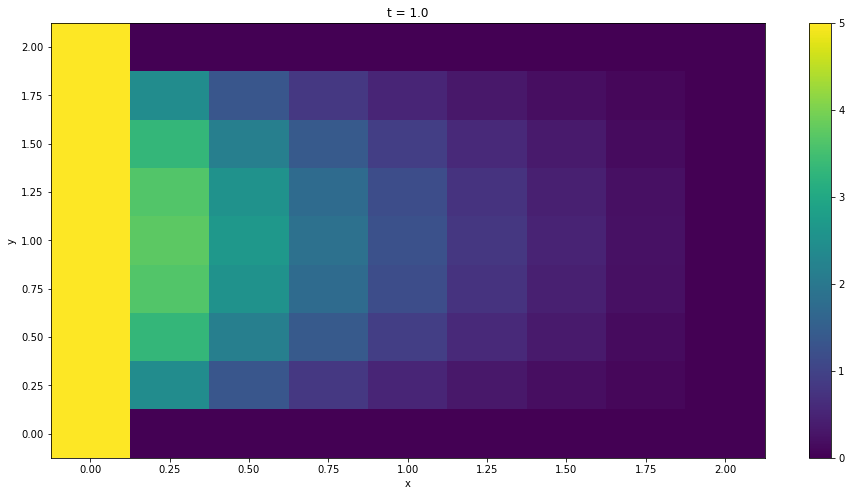

In [87]:
Sol2Anim(limits_i, implicit_solution)

Бачимо чудове зображення розповсюдження тепла по простору. У вкладеннях також є анімація цього процесу.

### Висновки
Для моделювання використано неявну двошарову схему Кранка-Нікольсона із ваговим коефіцієнтом.

Результати моделювання узгоджуються з очікуваннями